## Setup and Data Loading

In [11]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('pokemon_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")

Dataset loaded: 1025 rows, 43 columns



In [12]:
# Top 17 features identified from baseline analysis
top_17_features = [
    'Base Stat Total', 'Special Attack Stat', 'Special Defense Stat',
    'Attack Stat', 'Defense Stat', 'Health Stat', 'Speed Stat',
    'Offensive Total', 'Special Offense', 'Physical Offense',
    'Defensive Total', 'Special Defense Total', 'Physical Defense',
    'Stat Variance', 'Catch Rate', 'Base Happiness', 'Has Hidden Ability'
]

# Prepare data
X = df[top_17_features]
y = df['Is Legendary']

# Split data (same split as baseline for comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")
print(f"Features: {len(top_17_features)}")

Train set: 768 rows
Test set: 257 rows
Features: 17


## Cross-Validation on Baseline Models

In [13]:
# Logistic Regression CV
print("Logistic Regression - 5-Fold Cross-Validation:")
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
cv_scores_lr = cross_val_score(lr_baseline, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"  F1 Scores: {cv_scores_lr}")
print(f"  Mean F1: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})\n")

# Random Forest CV
print("Random Forest - 5-Fold Cross-Validation:")
rf_baseline = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_val_score(rf_baseline, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"  F1 Scores: {cv_scores_rf}")
print(f"  Mean F1: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

Logistic Regression - 5-Fold Cross-Validation:
  F1 Scores: [0.66666667 0.66666667 0.73333333 0.58333333 0.62068966]
  Mean F1: 0.6541 (+/- 0.0504)

Random Forest - 5-Fold Cross-Validation:
  F1 Scores: [0.86666667 0.78571429 0.86666667 0.92857143 0.83870968]
  Mean F1: 0.8573 (+/- 0.0463)


## Hyperparameter Tuning - Logistic Regression

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.7121

Test Set Performance:
  Accuracy:  0.9222
  Precision: 0.5750
  Recall:    0.8846
  F1 Score:  0.6970

Confusion Matrix:
                  Predicted Normal  Predicted Legendary
Actual Normal                  214                   17
Actual Legendary                 3                   23


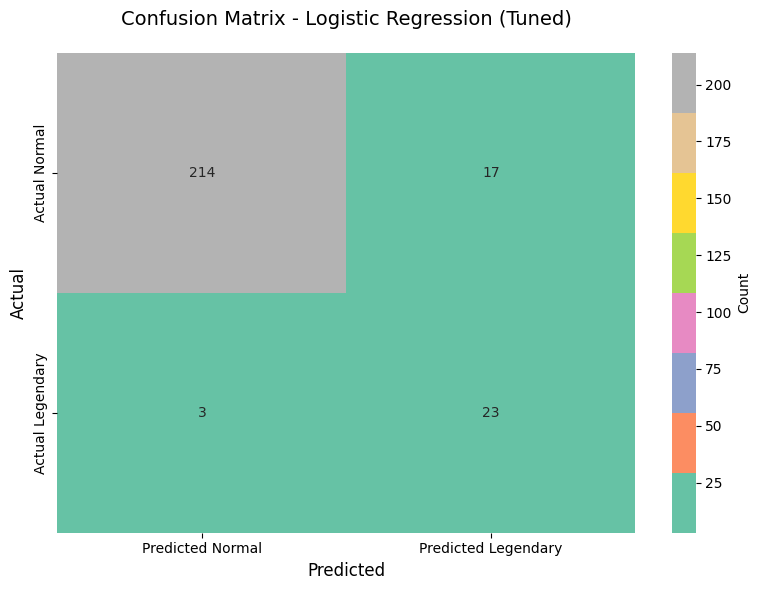

In [14]:
# Define parameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# Grid search with cross-validation
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_lr.best_params_}")
print(f"Best cross-validation F1 score: {grid_lr.best_score_:.4f}")

# Evaluate on test set
lr_tuned = grid_lr.best_estimator_
y_pred_lr_tuned = lr_tuned.predict(X_test_scaled)

lr_tuned_acc = accuracy_score(y_test, y_pred_lr_tuned)
lr_tuned_prec = precision_score(y_test, y_pred_lr_tuned)
lr_tuned_rec = recall_score(y_test, y_pred_lr_tuned)
lr_tuned_f1 = f1_score(y_test, y_pred_lr_tuned)
lr_tuned_cm = confusion_matrix(y_test, y_pred_lr_tuned)

print("\nTest Set Performance:")
print(f"  Accuracy:  {lr_tuned_acc:.4f}")
print(f"  Precision: {lr_tuned_prec:.4f}")
print(f"  Recall:    {lr_tuned_rec:.4f}")
print(f"  F1 Score:  {lr_tuned_f1:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(
    lr_tuned_cm,
    columns=['Predicted Normal', 'Predicted Legendary'],
    index=['Actual Normal', 'Actual Legendary']
))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lr_tuned_cm, annot=True, fmt='d', cmap='Set2', 
            xticklabels=['Predicted Normal', 'Predicted Legendary'],
            yticklabels=['Actual Normal', 'Actual Legendary'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression (Tuned)', fontsize=14, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('figures/models/conf_mat_legendary_lr_tuned.png', bbox_inches='tight', dpi=300)
plt.show()

## Hyperparameter Tuning - Random Forest

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'class_weight': None}
Best cross-validation F1 score: 0.8797

Test Set Performance:
  Accuracy:  0.9844
  Precision: 0.9583
  Recall:    0.8846
  F1 Score:  0.9200

Confusion Matrix:
                  Predicted Normal  Predicted Legendary
Actual Normal                  230                    1
Actual Legendary                 3                   23


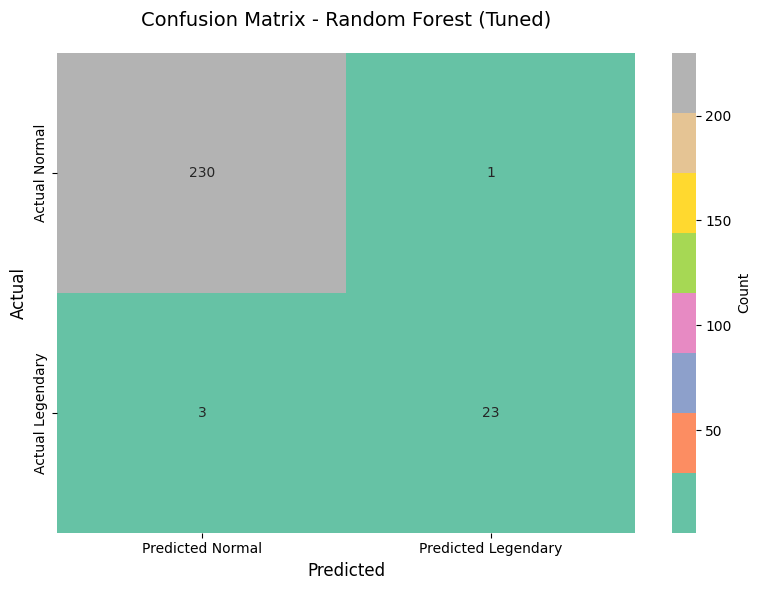

In [15]:
# Define parameter distribution for Random Search
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Randomized search (more efficient for Random Forest)
random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist_rf,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_rf.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {random_rf.best_params_}")
print(f"Best cross-validation F1 score: {random_rf.best_score_:.4f}")

# Evaluate on test set
rf_tuned = random_rf.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)

rf_tuned_acc = accuracy_score(y_test, y_pred_rf_tuned)
rf_tuned_prec = precision_score(y_test, y_pred_rf_tuned)
rf_tuned_rec = recall_score(y_test, y_pred_rf_tuned)
rf_tuned_f1 = f1_score(y_test, y_pred_rf_tuned)
rf_tuned_cm = confusion_matrix(y_test, y_pred_rf_tuned)

print("\nTest Set Performance:")
print(f"  Accuracy:  {rf_tuned_acc:.4f}")
print(f"  Precision: {rf_tuned_prec:.4f}")
print(f"  Recall:    {rf_tuned_rec:.4f}")
print(f"  F1 Score:  {rf_tuned_f1:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(
    rf_tuned_cm,
    columns=['Predicted Normal', 'Predicted Legendary'],
    index=['Actual Normal', 'Actual Legendary']
))
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_tuned_cm, annot=True, fmt='d', cmap='Set2', 
            xticklabels=['Predicted Normal', 'Predicted Legendary'],
            yticklabels=['Actual Normal', 'Actual Legendary'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest (Tuned)', fontsize=14, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('figures/models/conf_mat_legendary_rf_tuned.png', bbox_inches='tight', dpi=300)
plt.show()

## Model Comparison - Baseline vs Tuned

In [16]:
# Train baseline models for fair comparison
lr_baseline.fit(X_train_scaled, y_train)
rf_baseline.fit(X_train_scaled, y_train)

y_pred_lr_base = lr_baseline.predict(X_test_scaled)
y_pred_rf_base = rf_baseline.predict(X_test_scaled)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)',
        'Logistic Regression (Tuned)',
        'Random Forest (Baseline)',
        'Random Forest (Tuned)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_base),
        lr_tuned_acc,
        accuracy_score(y_test, y_pred_rf_base),
        rf_tuned_acc
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr_base),
        lr_tuned_prec,
        precision_score(y_test, y_pred_rf_base),
        rf_tuned_prec
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr_base),
        lr_tuned_rec,
        recall_score(y_test, y_pred_rf_base),
        rf_tuned_rec
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr_base),
        lr_tuned_f1,
        f1_score(y_test, y_pred_rf_base),
        rf_tuned_f1
    ]
})

print(comparison_df.to_string(index=False),"\n")

# Identify best model
best_model_idx = comparison_df['F1 Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1 Score']

print(f"Best Model: {best_model_name}")
print(f"Best F1 Score: {best_f1:.4f}")

                         Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression (Baseline)  0.933852   0.714286 0.576923  0.638298
   Logistic Regression (Tuned)  0.922179   0.575000 0.884615  0.696970
      Random Forest (Baseline)  0.984436   0.958333 0.884615  0.920000
         Random Forest (Tuned)  0.984436   0.958333 0.884615  0.920000 

Best Model: Random Forest (Baseline)
Best F1 Score: 0.9200
